In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

c:\Users\Vincent\.conda\envs\tf_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [4]:
for pt_examples, en_examples in train_examples.batch(5).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
`` `` '' podem usar tudo sobre a mesa no meu corpo . ''

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .


In [5]:
#use BERT tokenizer
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizers = tf.saved_model.load(model_name)

In [7]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [8]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .


In [9]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]
[2, 79, 94, 212, 299, 92, 71, 1356, 92, 114, 15, 3]


In [10]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .


In [11]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ,
 [b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance',
  b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic', b',',
  b'can', b'still', b'have', b'faith', b'.', b'[END]']                     ,
 [b'[START]', b'you', b'can', b'use', b'everything', b'on', b'the',
  b'table', b'on', b'me', b'.', b'[END]']                          ]>

In [12]:
#token amount visualization

lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

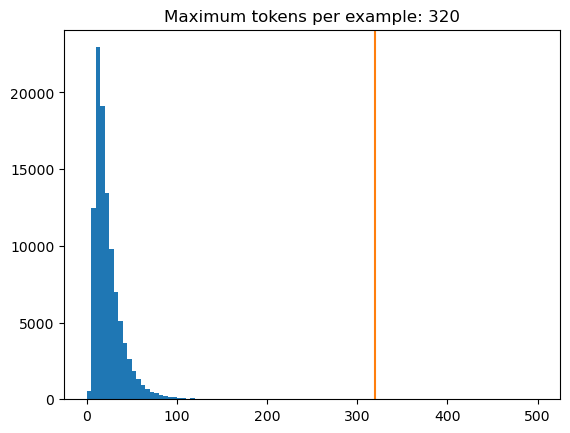

In [13]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');